In [137]:
import pickle as pkl
from xgboost import plot_importance
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from imblearn.over_sampling import SMOTE
from matplotlib import rcParams

%config InlineBackend.figure_formats = ['retina']  # or svg
%matplotlib inline

colors = ['#e898ac', '#00cfcc', '#ff9973', '#002845']

In [177]:
#set the rc parameters
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('ggplot')
plt.rc('font', size=20)
#SCORERS.keys()

load model

In [67]:
model = pkl.load(open("../Models/xgb_balanced.pkl", "rb"))   

load data

In [68]:
df = pd.read_pickle('../Data/survey_data_cleaned2.pkl')

Balance data

In [256]:
X = df[['database_count', 'Age1stCode', 'YearsCodePro', 'Age','YearsCode', 'EdLevel', 
         'Gender', 'UndergradMajor', 'Region', 
        'Hobbyist', 'back-end', 'full-stack', 'front-end', 'desktop', 'mobile', 'DevOps', 'Database admin', 
        'Designer','System admin', 'Student', 'Other Occupation', 'Retired Dev','Sometimes Code at Work', 
       'JavaScript', 'Python', 'SQL', 'Java', 'HTML/CSS']]
y = df['OpSys']

X = pd.get_dummies(X)

X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X,y)
len(df)

77604

In [70]:
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [71]:
X.columns

Index(['database_count', 'Age1stCode', 'YearsCodePro', 'Age', 'YearsCode',
       'EdLevel_AA/AS', 'EdLevel_BA/BS', 'EdLevel_MA/PhD', 'EdLevel_None',
       'EdLevel_Prof', 'EdLevel_Some Univ', 'EdLevel_Student', 'Gender_Man',
       'Gender_Woman', 'Gender_gender non-conforming', 'UndergradMajor_Arts',
       'UndergradMajor_Comp Sci/Eng', 'UndergradMajor_Eng',
       'UndergradMajor_Health/Nat Sci', 'UndergradMajor_Human/Social Sci',
       'UndergradMajor_Info Tech/Sys', 'UndergradMajor_Math/Stats',
       'UndergradMajor_None', 'UndergradMajor_Web Dev', 'Region_Africa',
       'Region_Asia', 'Region_Australia', 'Region_Baltics', 'Region_CIS',
       'Region_Europe', 'Region_M East', 'Region_N America',
       'Region_S America', 'Region_other', 'Hobbyist_No', 'Hobbyist_Yes',
       'back-end_No', 'back-end_Yes', 'full-stack_No', 'full-stack_Yes',
       'front-end_No', 'front-end_Yes', 'desktop_No', 'desktop_Yes',
       'mobile_No', 'mobile_Yes', 'DevOps_No', 'DevOps_Yes',
       

In [72]:
X_smoted_cat = X_smoted[[ 
                           'EdLevel_AA/AS', 'EdLevel_BA/BS', 'EdLevel_MA/PhD', 'EdLevel_None',
                           'EdLevel_Prof', 'EdLevel_Some Univ', 'EdLevel_Student', 'Gender_Man',
                           'Gender_Woman', 'Gender_gender non-conforming', 'UndergradMajor_Arts',
                           'UndergradMajor_Comp Sci/Eng', 'UndergradMajor_Eng',
                           'UndergradMajor_Health/Nat Sci', 'UndergradMajor_Human/Social Sci',
                           'UndergradMajor_Info Tech/Sys', 'UndergradMajor_Math/Stats',
                           'UndergradMajor_None', 'UndergradMajor_Web Dev', 'Region_Africa',
                           'Region_Asia', 'Region_Australia', 'Region_Baltics', 'Region_CIS',
                           'Region_Europe', 'Region_M East', 'Region_N America',
                           'Region_S America', 'Region_other', 'Hobbyist_No', 'Hobbyist_Yes',
                           'back-end_No', 'back-end_Yes', 'full-stack_No', 'full-stack_Yes',
                           'front-end_No', 'front-end_Yes', 'desktop_No', 'desktop_Yes',
                           'mobile_No', 'mobile_Yes', 'DevOps_No', 'DevOps_Yes',
                           'Database admin_No', 'Database admin_Yes', 'Designer_No',
                           'Designer_Yes', 'System admin_No', 'System admin_Yes', 'Student_No',
                           'Student_Yes', 'Other Occupation_No', 'Other Occupation_Yes',
                           'Retired Dev_No', 'Retired Dev_Yes', 'Sometimes Code at Work_No',
                           'Sometimes Code at Work_Yes', 'JavaScript_No', 'JavaScript_Yes',
                           'Python_No', 'Python_Yes', 'SQL_No', 'SQL_Yes', 'Java_No', 'Java_Yes',
                           'HTML/CSS_No', 'HTML/CSS_Yes']]
X_smoted_num = X_smoted[['database_count', 'Age1stCode', 'YearsCodePro', 'Age','YearsCode']]

X_balanced = undummify(X_smoted_cat)

Concat into df2

In [73]:
df2 = df = pd.concat((X_balanced,X_smoted_num, y_smoted), axis=1)
#print(df2)

# EDA of Balanced Data

In [74]:
df2['OpSys'].value_counts()

Linux-based    25868
MacOS          25868
Windows        25868
Name: OpSys, dtype: int64

### Plot feature importance

In [242]:
features = ['database_count', 'Age1stCode', 'YearsCodePro', 'Age', 'YearsCode',
       'EdLevel_BA/BS', 'EdLevel_MA/PhD', 'No Education', 'Professional Degree',
       'EdLevel_Some Univ', 'Current Student', 'Gender_Woman',
       'Gender_gender non-conforming', 'UndergradMajor_Comp Sci/Eng',
       'UndergradMajor_Eng', 'UndergradMajor_Health/Nat Sci',
       'UndergradMajor_Human/Social Sci', 'UndergradMajor_Info Tech/Sys',
       'UndergradMajor_Math/Stats', 'No Undergrad Major',
       'Web Developement Undergrad Major', 'Region_Asia', 'Australia Region',
       'Baltics Region', 'Region_CIS', 'Region_Europe', 'Middle East Region',
       'Region_N America', 'Region_S America', 'Region_other', 'Hobbyist_Yes',
       'back-end_Yes', 'full-stack_Yes', 'front-end_Yes', 'Desktop Developer',
       'mobile_Yes', 'DevOps_Yes', 'Database admin_Yes', 'Designer_Yes',
       'System admin_Yes', 'Student_Yes', 'Other Occupation_Yes',
       'Retired Developer', 'Sometimes Code at Work_Yes', 'JavaScript_Yes',
       'Python_Yes', 'SQL_Yes', 'Java_Yes', 'HTML/CSS_Yes']

feat_importance = list(model.feature_importances_)

# df_imp_feats = pd.DataFrame(feat_importance, columns = features )

In [243]:
plotdata = pd.DataFrame({"importances": feat_importance}, index=features)
print(plotdata)

                                  importances
database_count                       0.010902
Age1stCode                           0.012055
YearsCodePro                         0.011443
Age                                  0.011404
YearsCode                            0.011338
EdLevel_BA/BS                        0.009719
EdLevel_MA/PhD                       0.012273
No Education                         0.034684
Professional Degree                  0.036371
EdLevel_Some Univ                    0.014942
Current Student                      0.032426
Gender_Woman                         0.020354
Gender_gender non-conforming         0.021289
UndergradMajor_Comp Sci/Eng          0.011655
UndergradMajor_Eng                   0.023394
UndergradMajor_Health/Nat Sci        0.022873
UndergradMajor_Human/Social Sci      0.028119
UndergradMajor_Info Tech/Sys         0.023415
UndergradMajor_Math/Stats            0.027371
No Undergrad Major                   0.034472
Web Developement Undergrad Major  

In [102]:
top_feats = plotdata.sort_values('importances', ascending=False).head(10)

<AxesSubplot:>

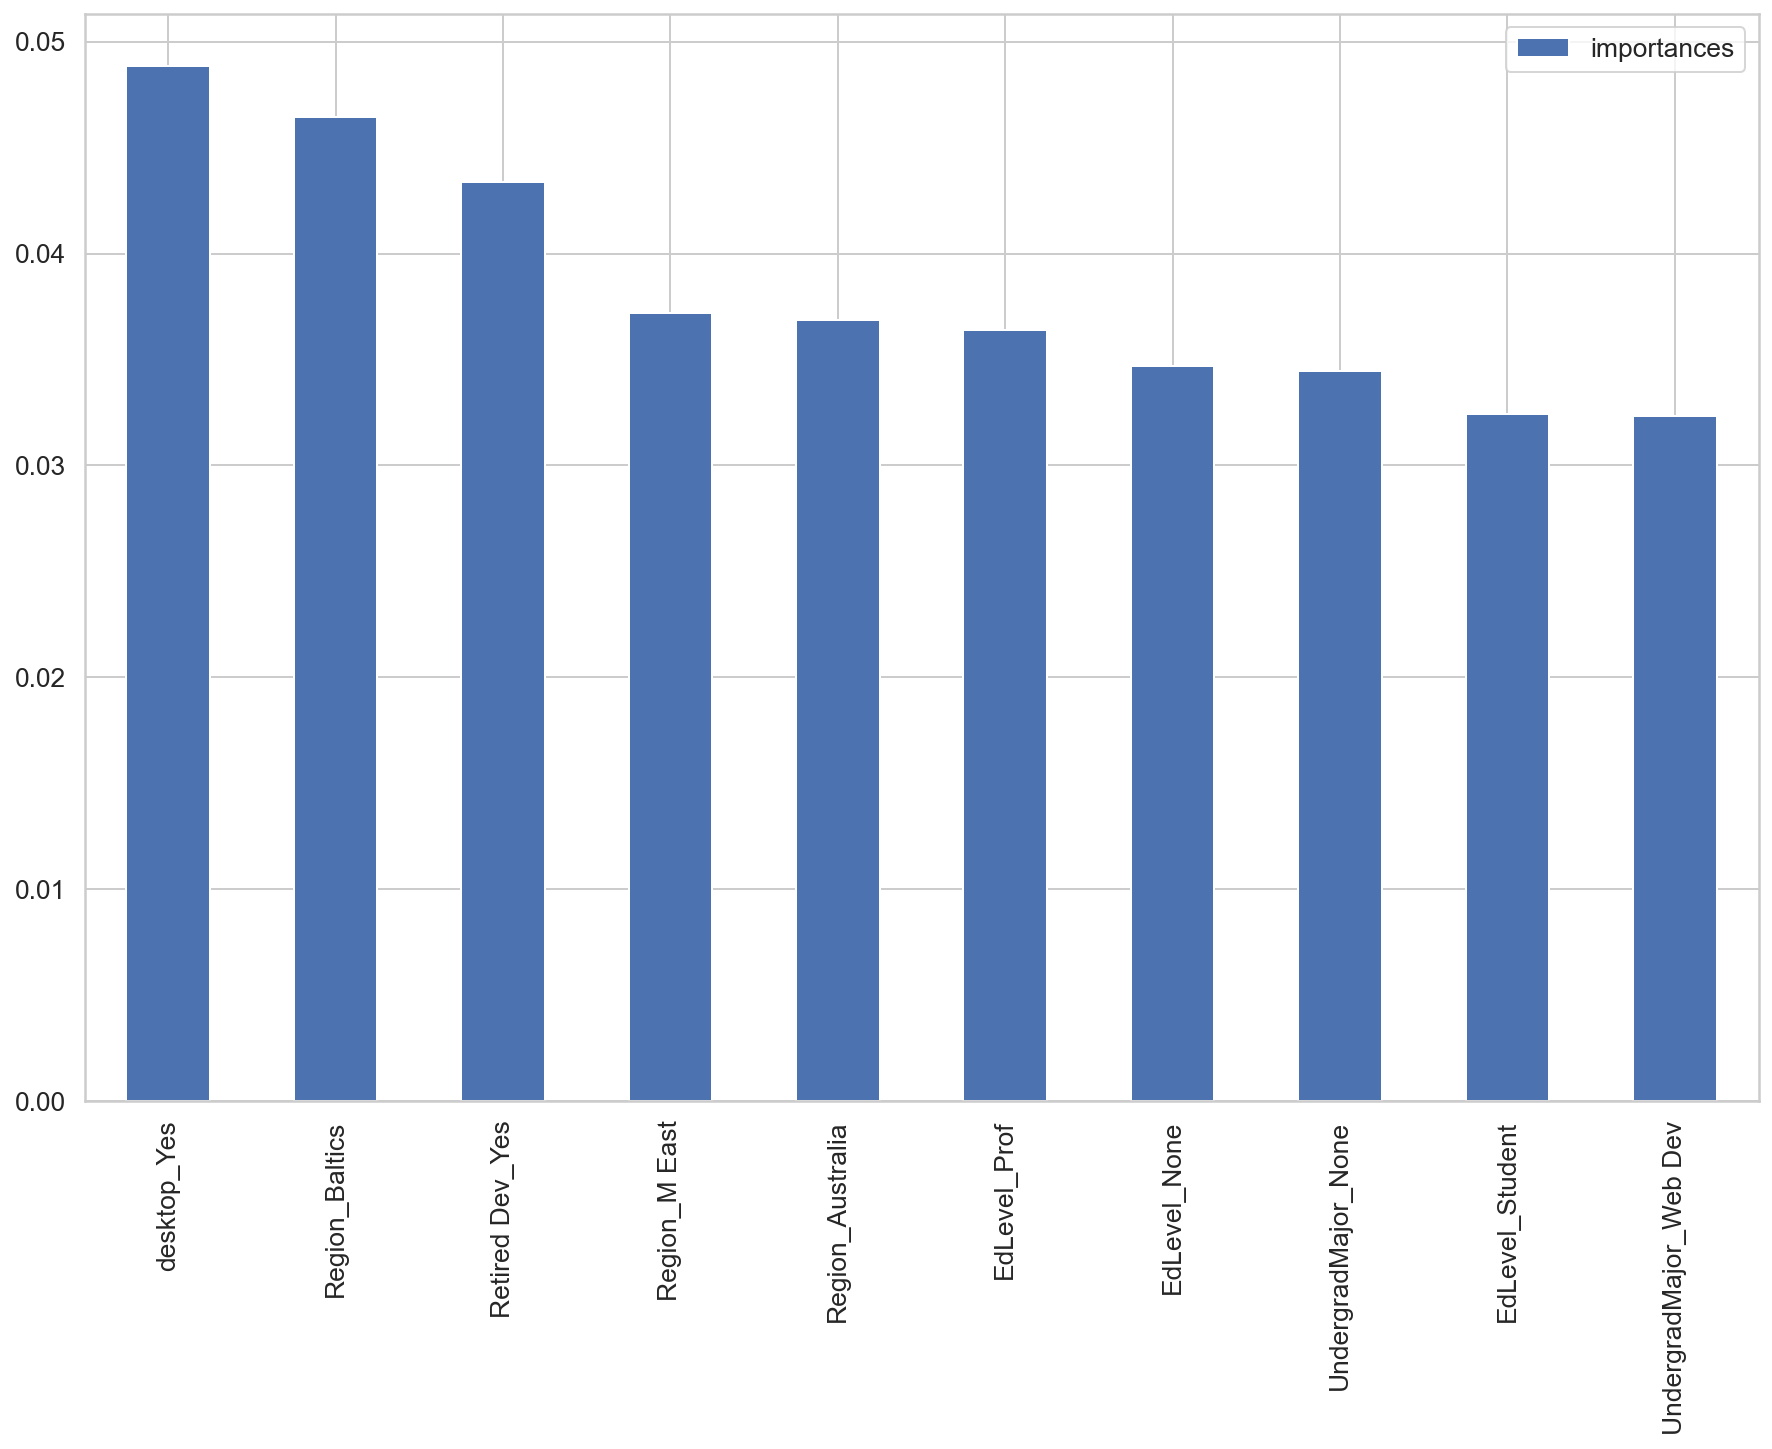

In [103]:
top_feats.plot(kind='bar')
# plt.bar(df_imp_feats.columns, df_imp_feats[:,0:1])
# plt.xticks(rotation=90)
# plt.show()

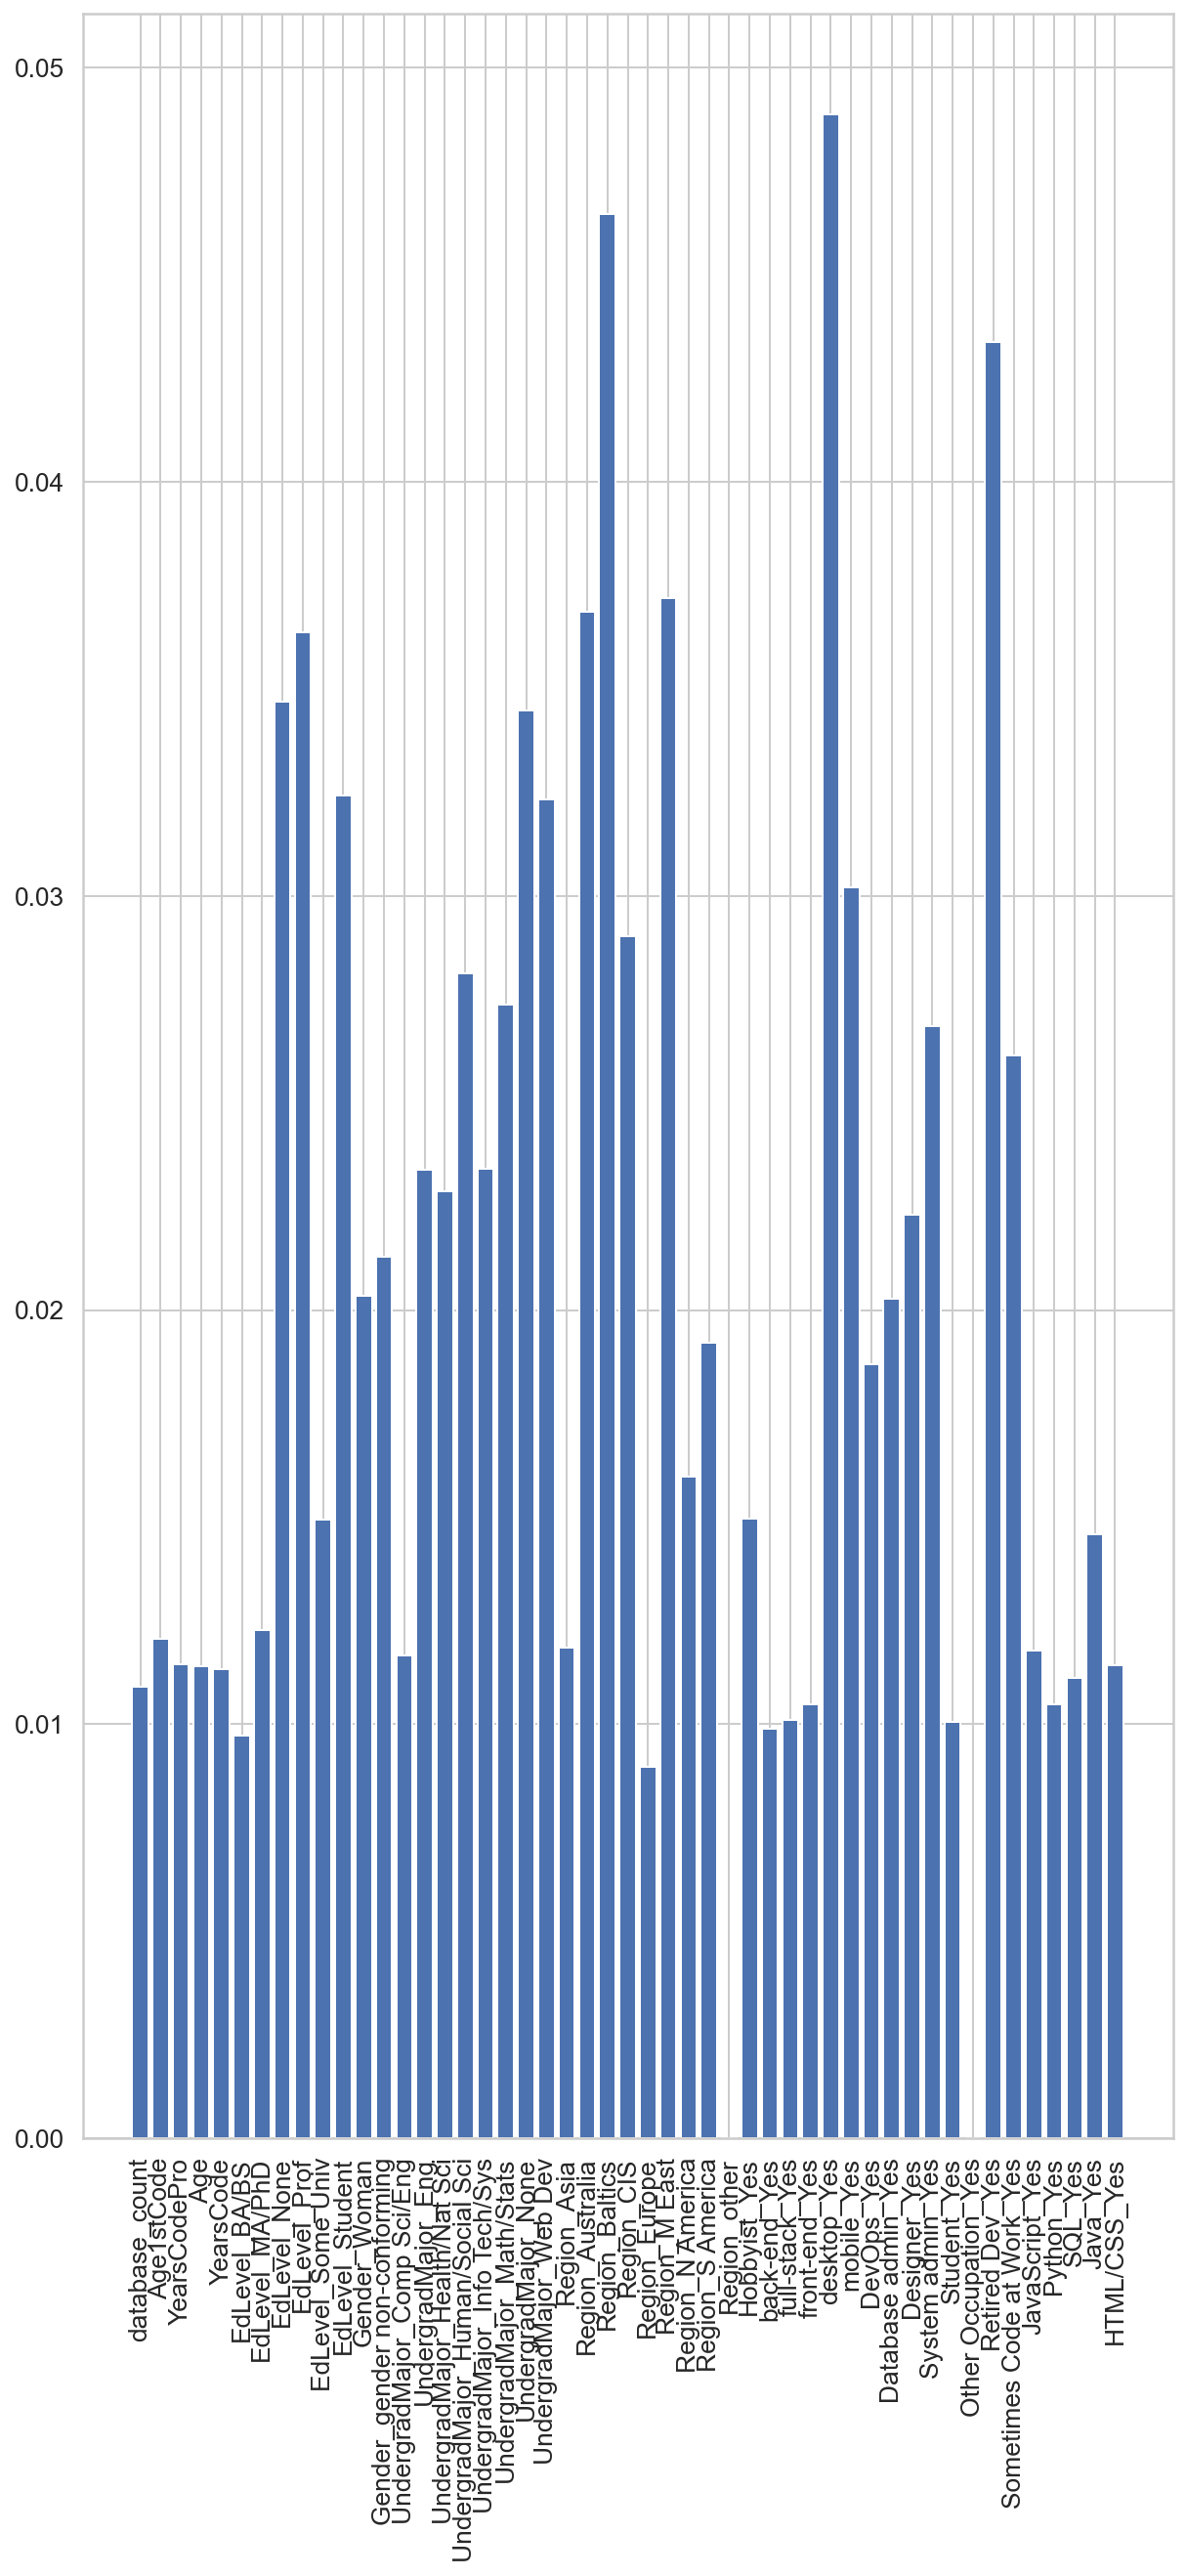

In [80]:
model.feature_importances_
plt.bar(features, model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

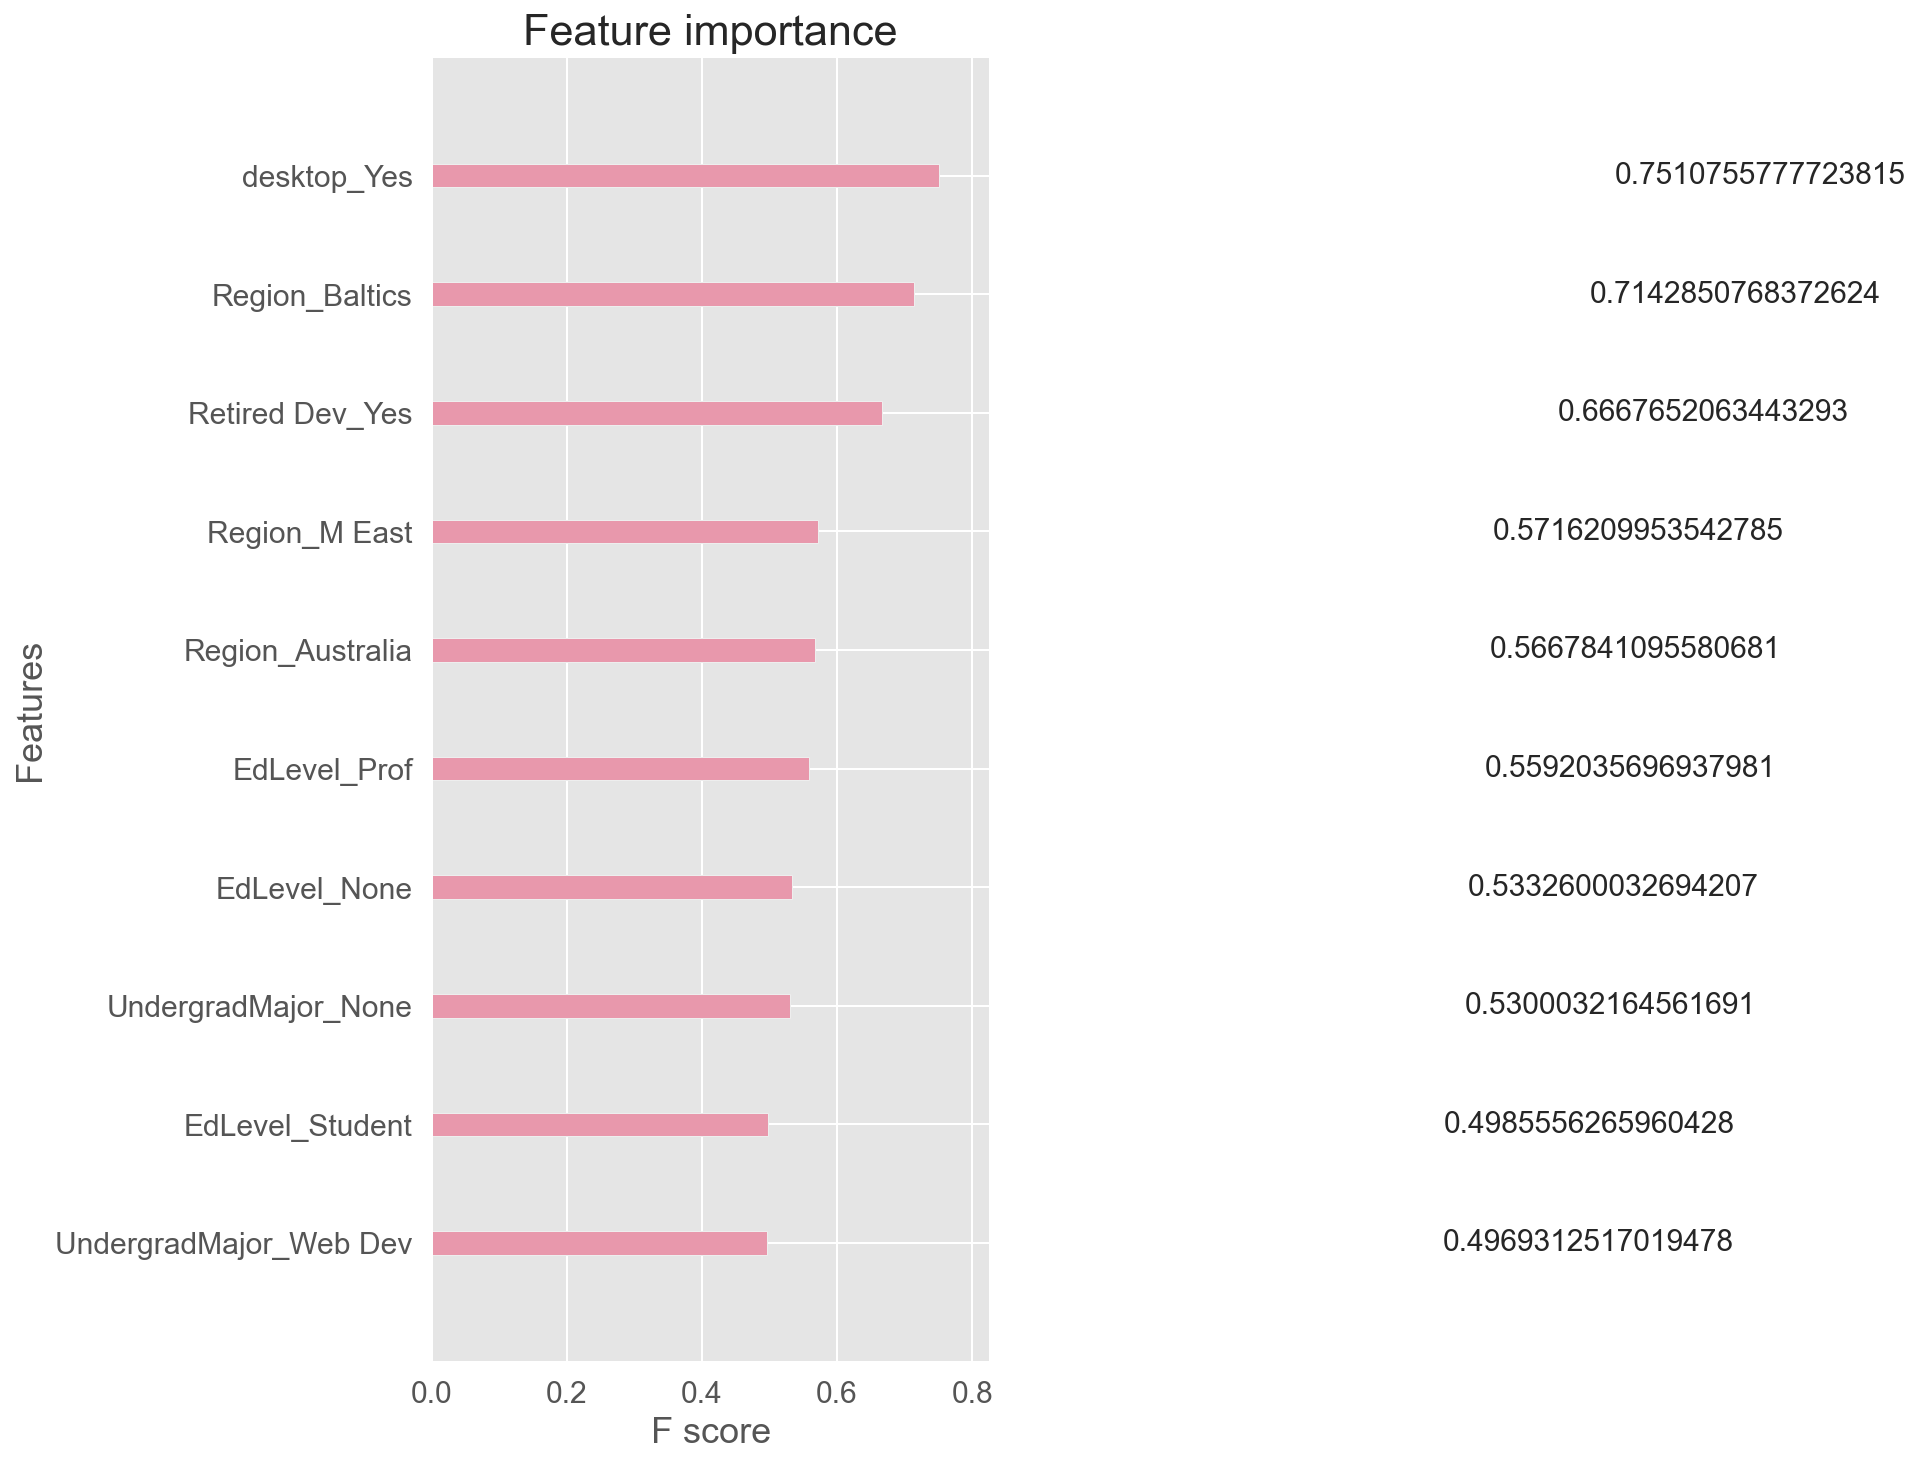

In [247]:
rcParams['figure.figsize'] = [5,12]
rcParams['legend.fontsize'] = 15
rcParams['font.size'] = 15
rcParams['xtick.labelsize']=15
rcParams['ytick.labelsize']=15
# xgb.plot_importance(model)
imp = plot_importance(model, importance_type='gain', max_num_features=10, color='#e898ac')
plt.show()
imp.figure.savefig('../Graphs/importance.png')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.466933 to fit


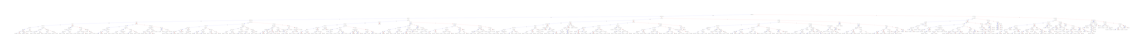

In [23]:
xgb.plot_tree(model, num_trees=0)
plt.rcParams['figure.figsize'] = [50, 15]
plt.show()